#### Loading libraries

* Create .env
* Update in .env, to load as enviroment variable
    * OPENAI_API_KEY  : OpenAI
    * TAVILY_API_KEY  : for search results
    * LANGSMITH_API_KEY : For Langsmith debugging
    * LANGCHAIN_PROJECT: For Langsmith project level debgging
    * LANGCHAIN_TRACING_V2 : For tracking the via Langsmith
* Please feel free to remove unused imports



In [1]:
import os
import json
import warnings

import ast
import operator

from typing import Any, Dict, List, TypedDict, Annotated

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, START, END

from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field
from IPython.display import Image, display


from connections.chat_openai_conn import OpenAIConnection

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# Loads environment variables OpenAI key, Tavily key, langsmith, etc
load_dotenv()

True

#### Connecing to Openai

* from openai import OpenAI

In [2]:
OpenAIConnection()

Sucessfully connected to OpenAI
Sucessfully connected to Chat OpenAI
Sucessfully connected to OpenAI


#### Connecting langchain openai
 * from langchain_openai import ChatOpenAI
  * I have written custom class please write you own logic


In [3]:
llm_chat = OpenAIConnection.get_chat_openai()

 * from openai import OpenAI
  * I have written custom class please write you own logic

In [4]:
llm_client = OpenAIConnection.get_openai()

#### Optional if you want to use

In [5]:
#### optional
warnings.filterwarnings('ignore')
search_tool = TavilySearchResults(
    # top n website you want to access from the serach results
    max_results=2,
    search_depth="basic",
    include_answer=True
)


* Go in-detail at blog or website level
* Get top 20 or 30 and consider only the critical websites like arxiv, medium, etc
* Use selenium web browser access the url data
    * Implement Rag if it's a search approach
    * For this use case take summary of each page

In [6]:
output = search_tool.invoke("What are the recent developments in Reinforcement Learning?")
output

[{'title': '[D][R]Recent developments in Reinforcement Learning - Reddit',
  'url': 'https://www.reddit.com/r/MachineLearning/comments/1b81pkt/drrecent_developments_in_reinforcement_learning/',
  'content': 'RLHF is a big jump for RL. And yes, it definitely is RL. There are two training stages, pretraining, and fine tuning for instruction following.',
  'score': 0.7869018},
 {'title': 'Advancements and Challenges in Continual Reinforcement Learning',
  'url': 'https://arxiv.org/html/2506.21899v1',
  'content': 'Special emphasis is placed on recent advancements in continual reinforcement learning ... Recent advances in hierarchical reinforcement learning.',
  'score': 0.66959417}]

#### Sanity check

In [7]:
out = llm_chat.invoke("Who is the CEO of Google?")
out

AIMessage(content='As of June 2024, the CEO of Google is Sundar Pichai.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 14, 'total_tokens': 32, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CSJqPCE2KxJoCYtKUtNXdRtJNJjMh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bcbd5834-ee8c-4c45-abf6-46841e983332-0', usage_metadata={'input_tokens': 14, 'output_tokens': 18, 'total_tokens': 32, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
out = llm_client.chat.completions.create(
    model="gpt-4o-mini-search-preview-2025-03-11",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user" ,"content":"Who is the CEO of Google?"}]
)

In [9]:
out
#out.choices[0].message.content

ChatCompletion(id='chatcmpl-9d04883b-747d-46d0-aa6f-7bcd9ca2c578', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Sundar Pichai is the Chief Executive Officer (CEO) of Google. He joined Google in 2004 and became CEO in 2015. In 2019, he also became the CEO of Alphabet Inc., Google's parent company. ([britannica.com](https://www.britannica.com/biography/Sundar-Pichai?utm_source=openai)) ", refusal=None, role='assistant', annotations=[Annotation(type='url_citation', url_citation=AnnotationURLCitation(end_index=274, start_index=186, title='Sundar Pichai | Biography, Google, & Facts | Britannica Money', url='https://www.britannica.com/biography/Sundar-Pichai?utm_source=openai'))], audio=None, function_call=None, tool_calls=None))], created=1760865509, model='gpt-4o-mini-search-preview-2025-03-11', object='chat.completion', service_tier=None, system_fingerprint='', usage=CompletionUsage(completion_tokens=79, prompt_tokens=13, total_token

#### Defining state wrt Agents

In [10]:
# Please modify as per your requirements and use case
class State(TypedDict):
    query: str
    response: str
    actions: List[dict]
    messages: Annotated[list, add_messages]
    count: int = Field(default=0)
    output: str

In [11]:
def supervisor(state: State):
    """
    Decides what's the plan and action to be taken
    :param state:
    :return:
    """
    try:
        # If actions are not their for the first time run else directly return
        if "actions" not in state or len(state.get("actions",[]))==0:

            ### Rubric Prompt
            prompt = """SYSTEM: You are the Supervisor agent (Agent A).
            Your job:
                1. Give a multi-step plan
                2. Choose the single best agent to execute plan at each step.
                3. Use the Agent Manifest and the Selection Rubric below.
                4. Produce only JSON Array of objects one per step with the fields:
                    - step_id (int)
                    - step (int)
                    - selected_agent (one of the available agents)
                    - reason (one sentence)
                    - confidence (0-1 numeric)

            AGENT MANIFEST:
            researcher | Retriever/Document search | Fast at finding the latest research or releases in that particular area
            analyzer | Analysis of content | Does analysis of the various content available and gives high level insights of important content.
            summarizer | Summary of the content | Give summary in layman terms such that anyone can understand at ease.

            SELECTION RUBRIC (in order of priority):
            1. If step asks to "search", "find", "retrieve" -> prefer researcher.
            2. If step asks for "analysis", "insights" -> prefer analyzer.
            3. If step asks for "summary", "draft" -> prefer summarizer.


            Given following statement give the steps : {val}

            Now evaluate each PLAN step and output the JSON array described above.
            """
            out = llm_chat.invoke(prompt)
            out = ast.literal_eval(out.content)
            print(f"Extracted supervisor output: {out}")
            state["actions"] = out

            # reversing so we can pop out the actions once complete
            if state["actions"]:
                state["actions"].reverse()
        return state
    except Exception as ex:
        print(f"Error in the master {type(ex).__name__}: {ex}")

#### Sanity check at agent level

In [30]:
# s = State(query="What are the most recent development in Reinforcement Learning?",
#           response="",
#           count=0,
#           actions=[],
#           decision=dict(),
#           messages=[],
#           output = ""
#           )
# o = supervisor(s)

In [16]:
def researcher(state: State):
    """
    Researcher is currently using pre-trained model
    # Please enhance using custom web tools the search with Selenium web browser or
    # Arxiv: which has papers published, code link: https://github.com/vajja/DeepLearningAI/blob/main/MCP/L3/L3.ipynb

    :param state:
    :return:
    """
    try:
        print(f"Started researcher agent for query: {state['query']}\n")
        if "messages" not in state:
            state["messages"] = []
        messages = state["messages"]

        # Further enhance the prompt
        prompt = f"""You are a helpful AI Research Assistant in the world.
        You help thousands of people across various platforms.
        Please can you share latest insights about the following query: {state['query']}
        - top 5 best available resources and content
        - content wrt each resource"""
        response = llm_chat.invoke([{"role": "system", "content": prompt}] + messages)

        state["messages"].append(response.content)
        state["response"] = response.content
        state["output"] = response.content

        print(f"🔍 Researcher says: {response.content[:100]}\n\n")
        print(f"Successfully completed researcher")
        return state
    except Exception as ex:
        print(f"Error in the researcher {type(ex).__name__}: {ex}")
    return state

In [18]:
def analyzer(state: State):
    """
    Analyzer analyzes the data from the researcher
    :param state:
    :return:
    """
    try:
        print(f"Started analyzer agent for query: {state['query']}")
        messages = state["messages"]

        # Modify the prompt and try to further enhance
        prompt = f"""You are AI text data analyzer.
        Content: {state["output"]}

        For the above content analyze the data verify if it's authentic.
        Try to further enhance the content further such that it makes sense."""
        response = llm_chat.invoke(prompt)
        state["messages"].append(response.content)
        state["response"] = response.content
        state["output"] = response.content
        print(f"🔍 Analyzer says: {response.content[:100]}\n")
        print("Successfully analyzed the data!")
        return state
    except Exception as ex:
        print(f"Error in the analyzer {type(ex).__name__}: {ex}")
    return state



In [19]:
def summarizer(state: State):
    try:
        print(f"started summarizer {state['query']}")
        messages = state["messages"]

        # Further enhance the prompt
        prompt = f"""You are AI text data summarizer.
        Content: {messages[-1]}

        For the above content try to summarize the output in less than 100-200 words such that anyone can understand at ease."""
        response = llm_chat.invoke(prompt)
        state["messages"].append(response.content)
        state["response"] = response.content
        state["output"] = state["response"]
        print(f"🔍 summarizer says: {response.content}\n")
        print("Successfully summarized the data!")
        return state
    except Exception as ex:
        print(f"Error in the summarizer {type(ex).__name__}: {ex}")
    return state

In [20]:
def route_decision(state: State):
    """
    based on the plan given by supervisor it would redirect
    to appropriate agent
    :param state:
    :return:
    """
    try:

        print(f'actions availabe: {state["actions"]}\n')
        if len(state["actions"]) >0:
            action = state["actions"].pop()
            o = action["selected_agent"]
            state["count"] += 1
            print(f"Action to take: {o}")
            return o
        return {"decision":"__end__"}
    except Exception as ex:
        print(f"Error in the route decision {type(ex).__name__}: {ex}")
    return {"decision":"__end__"}

#### Creating graph

In [21]:
builder = StateGraph(State)

#### Creating nodes

In [22]:
# Master Agent
builder.add_node("supervisor", supervisor)

# Decision router
builder.add_node("router", route_decision)

# other agent
builder.add_node("researcher", researcher)
builder.add_node("analyzer", analyzer)
builder.add_node("summarizer", summarizer)

#### Entry point

In [23]:
# Set entry point
builder.add_edge(START, "supervisor")

* Supervisor Plans
* Router directs to the agent
* Post execution of the agent the go bach to Supervisor
* Please feel free to add <b>human in loop</b> to further <b>re-run or iterative</b> prompt with feeback

In [24]:
builder.add_conditional_edges("supervisor", route_decision,
                 {
                     "researcher": "researcher",
                     "analyzer": "analyzer",
                     "summarizer": "summarizer",
                     "__end__": END} )

Post execution they would return to supervisor

In [25]:
builder.add_edge("researcher", "supervisor")

builder.add_edge("analyzer", "supervisor")
builder.add_edge("summarizer", "router")

In [26]:
# Compile graph
graph = builder.compile()

#### Visualize the graph

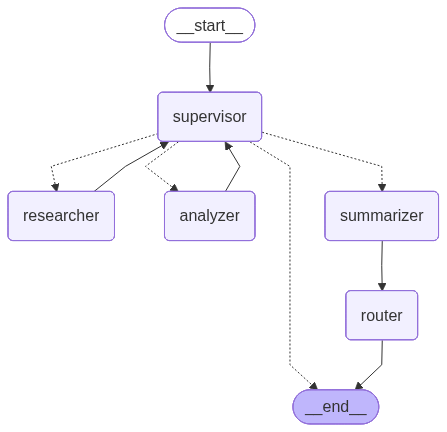

In [27]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
query = "What are the most recent development in Reinforcement Learning?"

In [29]:
inp_state = State(query=query,
                  response="",
                  count=0,
                  actions=[],
                  decision=dict(),
                  messages=[],
                  output = "")

In [30]:
output_state = graph.invoke(inp_state)

Extracted supervisor output: [{'step_id': 1, 'step': 1, 'selected_agent': 'researcher', 'reason': "The first step involves finding or retrieving relevant information, which fits the researcher's expertise.", 'confidence': 1}, {'step_id': 2, 'step': 2, 'selected_agent': 'analyzer', 'reason': 'The second step requires analyzing the retrieved content to extract high-level insights, best suited for the analyzer.', 'confidence': 1}, {'step_id': 3, 'step': 3, 'selected_agent': 'summarizer', 'reason': "The final step is to summarize the analyzed content in layman terms, which is the summarizer's specialty.", 'confidence': 1}]
actions availabe: [{'step_id': 3, 'step': 3, 'selected_agent': 'summarizer', 'reason': "The final step is to summarize the analyzed content in layman terms, which is the summarizer's specialty.", 'confidence': 1}, {'step_id': 2, 'step': 2, 'selected_agent': 'analyzer', 'reason': 'The second step requires analyzing the retrieved content to extract high-level insights, bes

It has messages of each state

In [34]:
#output_state["messages"]